In [1]:
#Datos y graficos

import pandas as pd
import numpy as np
import io # Usado para cargar datos de ejemplo desde un string
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y Pipelines
from sklearn.model_selection import train_test_split ,StratifiedKFold , cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier , XGBRegressor
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score , precision_score, recall_score

#Optimización tuning de hiperparámetros
import optuna

# Configuraciones
sns.set_style('whitegrid') # Estilo de gráficos
pd.set_option('display.max_columns', None) #mostrar todas las columnas al imprimir dataframes

c:\Users\inter\AppData\Local\pypoetry\Cache\virtualenvs\arboles-decision-zrGSN9Ih-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Leer archivo CSV
data= pd.read_csv("../Datos/e-shop clothing 2008.csv", sep=";")  # Cargar datos desde un archivo CSV

In [3]:
data

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165469,2008,8,13,1,29,24024,2,B10,2,4,1,67,1,1
165470,2008,8,13,1,9,24025,1,A11,3,4,1,62,1,1
165471,2008,8,13,1,34,24026,1,A2,3,1,1,43,2,1
165472,2008,8,13,2,34,24026,3,C2,12,1,1,43,1,1


In [4]:
df = data.copy() # Copia del df principal
df['Visited_Sale_Page'] = np.where(df['page 1 (main category)'] == 4, 1, 0) #Creación Flag 
df_filter = df.copy() #Copia del df para filtrar
df_filter = df_filter[df_filter['Visited_Sale_Page'] != 1] #Filtro de filas donde se entro a la pagina de ofertas

In [5]:
#Crear columnas agregadas (features) por 'session ID'

df_agg = df_filter.groupby('session ID').agg(
    total_clicks=('order', 'count'),
    max_price_seen=('price', 'max'),
    avg_price_seen=('price', 'mean'),
    countries=('country', pd.Series.nunique),
    main_category_mode=('page 1 (main category)', lambda x: x.mode()[0]),
    distinct_products=('page 2 (clothing model)', pd.Series.nunique)
).reset_index()

In [6]:
df_agg

,session ID,total_clicks,max_price_seen,avg_price_seen,countries,main_category_mode,distinct_products
0,1,7,57,41.857143,1,2,7
1,2,7,67,53.000000,1,2,5
2,3,5,48,42.000000,1,3,5
3,4,4,62,45.250000,1,1,4
4,5,1,57,57.000000,1,3,1
...,...,...,...,...,...,...,...
22279,24022,3,33,29.666667,1,1,3
22280,24023,4,38,35.500000,1,1,4
22281,24024,1,67,67.000000,1,2,1
22282,24025,1,62,62.000000,1,1,1


In [7]:
#Crear df con la variable objetivo por sesión
df_target = df.groupby('session ID')['Visited_Sale_Page'].max().reset_index()

In [8]:
#Hacer merge de features con variable objetivo
df_sesiones = pd.merge(df_agg, df_target, on='session ID')

In [9]:
#Proporción de clases en la variable objetivo
df_sesiones['Visited_Sale_Page'].value_counts(normalize=True)

Visited_Sale_Page
0    0.665679
1    0.334321
Name: proportion, dtype: float64

In [10]:
#Eliminar columna 'session ID' ya que no es necesaria para el modelado
df_sesiones.drop('session ID', axis=1, inplace=True)

In [11]:
df_sesiones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22284 entries, 0 to 22283
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_clicks        22284 non-null  int64  
 1   max_price_seen      22284 non-null  int64  
 2   avg_price_seen      22284 non-null  float64
 3   countries           22284 non-null  int64  
 4   main_category_mode  22284 non-null  int64  
 5   distinct_products   22284 non-null  int64  
 6   Visited_Sale_Page   22284 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 1.2 MB


## Pipiline de procesamiento

In [12]:
# Definir las columnas
numeric_features = ['total_clicks', 'max_price_seen', 'avg_price_seen']

# Seleccionar automáticamente todas las columnas 'object' como categóricas

categorical_features = df_sesiones.select_dtypes(include=['object', 'category']).columns.tolist()

for col in ['countries', 'main_category_mode', 'distinct_products']:
    if col not in categorical_features:
        categorical_features.append(col)

# Asegurarnos de que las numéricas no estén en la lista de categóricas
categorical_features = [col for col in categorical_features if col not in numeric_features and col != 'Visited_Sale_Page']

print(f"Features Numéricas: {numeric_features}")
print(f"Features Categóricas: {categorical_features}")

# Crear el transformador para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Imputar NAs con la mediana
    ('scaler', StandardScaler())                 # Escalar
])

# Crear el transformador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Imputar NAs con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))   # Aplicar One-Hot Encoding
])

# Combinar los transformadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Dejar pasar cualquier columna no especificada (aunque no debería haber)
)

print("\nPreprocesador creado exitosamente!")


Features Numéricas: ['total_clicks', 'max_price_seen', 'avg_price_seen']
Features Categóricas: ['countries', 'main_category_mode', 'distinct_products']

Preprocesador creado exitosamente!


## División de los datos de entrenamiento y de testeo

In [13]:
X = df_sesiones.drop('Visited_Sale_Page', axis=1)
y = df_sesiones['Visited_Sale_Page']

# Usamos un random_state fijo (ej. 42) para que nuestros resultados sean reproducibles
# Usamos 'stratify=y' para asegurar que la proporción de Churn sea la misma en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño de Train: {X_train.shape}")
print(f"Tamaño de Test: {X_test.shape}")

Tamaño de Train: (17827, 6)
Tamaño de Test: (4457, 6)


### Primer modelo: Regresión logistica

In [14]:
# Crear pipeline con preprocesador y regresión logística
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# Entrenar el pipeline
print("Entrenando el Pipeline de Regresión Logística...")
clf.fit(X_train, y_train)
print("Entrenamiento completado.")

# Evaluar el modelo
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("\n--- Reporte de Clasificación (Regresión Logística) ---")
print(classification_report(y_test, y_pred))

# Guardar métricas
logreg_accuracy = accuracy_score(y_test, y_pred)
logreg_f1 = f1_score(y_test, y_pred)
logreg_auc = roc_auc_score(y_test, y_prob)
logreg_precision = precision_score(y_test, y_pred, pos_label=1)
logreg_recall = recall_score(y_test, y_pred, pos_label=1)

Entrenando el Pipeline de Regresión Logística...
Entrenamiento completado.

--- Reporte de Clasificación (Regresión Logística) ---
              precision    recall  f1-score   support

           0       0.77      0.62      0.69      2967
           1       0.45      0.63      0.53      1490

    accuracy                           0.62      4457
   macro avg       0.61      0.63      0.61      4457
weighted avg       0.66      0.62      0.63      4457



### Segundo modelo: Arbol de decisión

In [15]:
# Crear pipeline con preprocesador y árbol de decisión
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Entrenar el pipeline
print("Entrenando el Pipeline de Árbol de Decisión...")
dt_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

# Evaluar
y_pred_dt = dt_pipeline.predict(X_test)
# Para árboles, predict_proba también está disponible
y_prob_dt = dt_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Reporte de Clasificación (Árbol de Decisión) ---")
print(classification_report(y_test, y_pred_dt))

# Guardar métricas
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_auc = roc_auc_score(y_test, y_prob_dt)
dt_precision = precision_score(y_test, y_pred_dt, pos_label=1)
dt_recall = recall_score(y_test, y_pred_dt, pos_label=1)

Entrenando el Pipeline de Árbol de Decisión...
Entrenamiento completado.

--- Reporte de Clasificación (Árbol de Decisión) ---
              precision    recall  f1-score   support

           0       0.71      0.74      0.72      2967
           1       0.43      0.40      0.42      1490

    accuracy                           0.63      4457
   macro avg       0.57      0.57      0.57      4457
weighted avg       0.62      0.63      0.62      4457



### Tercer modelo: Ramdon Forest

In [16]:
# Crear el Pipeline de Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1)) # n_jobs=-1 usa todos los cores
])

# Entrenar el pipeline
print("Entrenando el Pipeline de Random Forest...")
rf_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

# Evaluar
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1] # Probabilidad de la clase 1 (Churn)

print("\n--- Reporte de Clasificación (Random Forest) ---")
print(classification_report(y_test, y_pred_rf))

# Guardar métricas
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_prob_rf)
rf_precision = precision_score(y_test, y_pred_rf, pos_label=1)
rf_recall = recall_score(y_test, y_pred_rf, pos_label=1)

Entrenando el Pipeline de Random Forest...
Entrenamiento completado.

--- Reporte de Clasificación (Random Forest) ---
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      2967
           1       0.47      0.30      0.37      1490

    accuracy                           0.65      4457
   macro avg       0.58      0.56      0.56      4457
weighted avg       0.62      0.65      0.63      4457



### Cuarto modelo: XGBoost

In [17]:
# Calcular scale_pos_weight para manejar el desbalanceo
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

# Crear el Pipeline de XGBoost
# Nota: Añadimos 'use_label_encoder=False' y 'eval_metric='logloss'' 
# para evitar warnings comunes en versiones recientes de XGBoost.
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        random_state=42,
        max_depth=5, #Maxima profundidad del árbol
        min_sample_split=30, #Minimo número de muestras para dividir un nodo
        use_label_encoder=False, 
        eval_metric='logloss', 
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight # Ayudar con el desbalanceo
    ))
])

# Entrenar el pipeline
print("Entrenando el Pipeline de XGBoost...")
xgb_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

# Evaluar
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Reporte de Clasificación (XGBoost) ---")
print(classification_report(y_test, y_pred_xgb))

# Guardar métricas
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_prob_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb, pos_label=1)
xgb_recall = recall_score(y_test, y_pred_xgb, pos_label=1)

Scale Pos Weight: 1.99
Entrenando el Pipeline de XGBoost...


Entrenamiento completado.

--- Reporte de Clasificación (XGBoost) ---
              precision    recall  f1-score   support

           0       0.77      0.64      0.70      2967
           1       0.46      0.62      0.53      1490

    accuracy                           0.63      4457
   macro avg       0.61      0.63      0.61      4457
weighted avg       0.66      0.63      0.64      4457



c:\Users\inter\AppData\Local\pypoetry\Cache\virtualenvs\arboles-decision-zrGSN9Ih-py3.13\Lib\site-packages\xgboost\training.py:199: UserWarning: [08:34:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "min_sample_split", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Comparando los modelos

In [18]:
# Crear diccionario con métricas de cada modelo
metrics_dict = {
    'Modelo': ['Regresión Logística', 'Árbol de Decisión', 'Random Forest', 'XGBoost'],
    'Accuracy': [logreg_accuracy, dt_accuracy, rf_accuracy, xgb_accuracy],
    'F1 Score': [logreg_f1, dt_f1, rf_f1, xgb_f1],
    'ROC AUC': [logreg_auc, dt_auc, rf_auc, xgb_auc],
    'Precision': [logreg_precision, dt_precision, rf_precision, xgb_precision],
    'Recall': [logreg_recall, dt_recall, rf_recall, xgb_recall]
}

# Crear DataFrame
metrics_df = pd.DataFrame(metrics_dict)

print(metrics_df)

                Modelo  Accuracy  F1 Score   ROC AUC  Precision    Recall
0  Regresión Logística  0.622616  0.528323  0.670747   0.453757  0.632215
1    Árbol de Decisión  0.625084  0.417161  0.542570   0.434277  0.401342
2        Random Forest  0.650438  0.367695  0.606180   0.465092  0.304027
3              XGBoost  0.629347  0.526376  0.661449   0.459459  0.616107


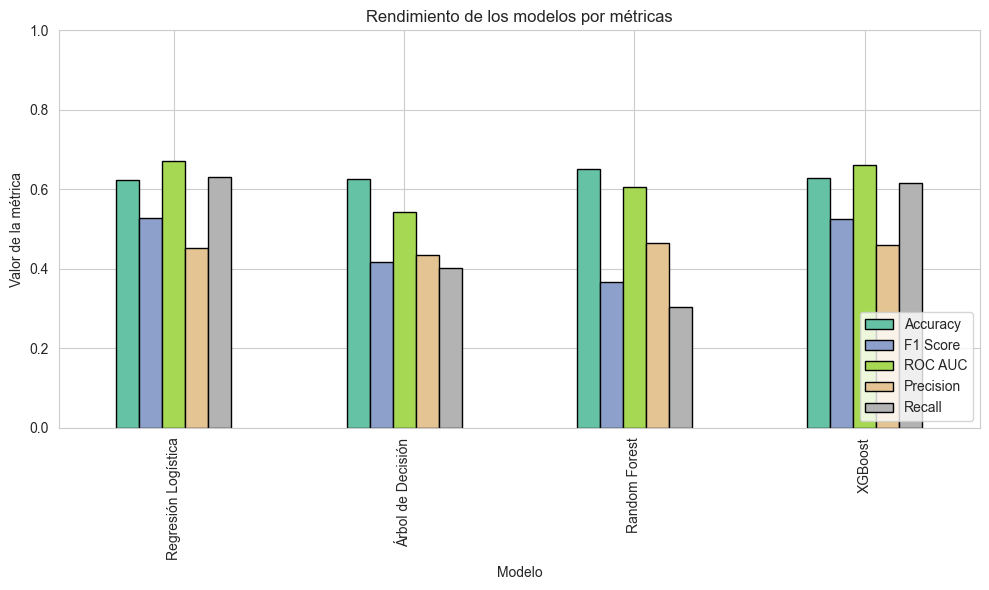

In [19]:
metrics_df.set_index('Modelo')[['Accuracy', 'F1 Score', 'ROC AUC', 'Precision', 'Recall']].plot(
    kind='bar', figsize=(10, 6), colormap='Set2', edgecolor='black'
)
plt.title('Rendimiento de los modelos por métricas')
plt.ylabel('Valor de la métrica')
plt.xlabel('Modelo')
plt.legend(loc='lower right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


### *Importancia de variables*

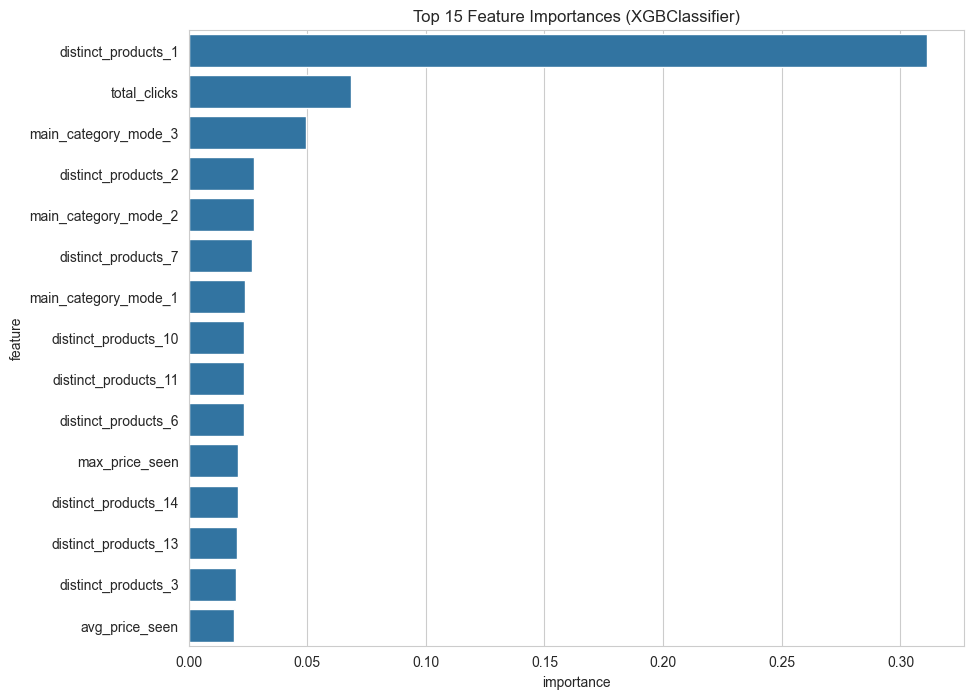

In [20]:
def plot_feature_importance(pipeline, top_n=15):
    try:
        # Extraer el modelo y el preprocesador del pipeline
        model = pipeline.named_steps['model']
        preprocessor = pipeline.named_steps['preprocessor']
        
        # Obtener los nombres de las features después del OneHotEncoding
        # 'cat' es el nombre que le dimos al transformador categórico
        ohe_features = preprocessor.named_transformers_['cat']\
                                   .named_steps['onehot']\
                                   .get_feature_names_out(categorical_features)
        
        # Combinar con los nombres de las features numéricas
        # 'num' es el nombre del transformador numérico
        feature_names = np.concatenate([numeric_features, ohe_features])
        
        # Obtener la importancia
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            model_name = model.__class__.__name__
        else:
            print("Este modelo no tiene 'feature_importances_'.")
            return

        # Crear un DataFrame de importancia
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)
        
        # Graficar
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
        plt.title(f'Top {top_n} Feature Importances ({model_name})')
        plt.show()
        
    except Exception as e:
        print(f"Error al obtener feature importance: {e}")
        print("Es posible que el pipeline no esté entrenado o la estructura no coincida.")

# Graficar importancia para XGBoost
plot_feature_importance(xgb_pipeline)

## Optimización Bayesiana con Optuna

### **Creación de bins, como estrategia de validación**

In [21]:
# Crear 5 grupos basados en el valor del CLV
y_bins = pd.cut(y, bins=5, labels=False)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_splits = list(skf.split(X, y_bins))

print(f"Validación configurada: 5 Folds estratificados por valor del cliente.")

Validación configurada: 5 Folds estratificados por valor del cliente.


### Creación de función objetivo a optimizar con Optuna, con XGBClassifier

In [22]:
def objective(trial):
    # Calcular peso para balanceo (si no lo has calculado externamente, calcula aquí)
    scale_pos_weight_calc = y_train.value_counts()[0] / y_train.value_counts()[1]

    # 1. Sugerencia de hiperparámetros (espacio de búsqueda)
    params = {
        'objective': 'binary:logistic',  # Clasificación binaria fija
        'n_jobs': -1,
        'random_state': 42,

        # Parámetros a optimizar
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', max(1, scale_pos_weight_calc * 0.5), scale_pos_weight_calc * 2.0),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'use_label_encoder': False,
        'eval_metric': 'logloss',  # Métrica para evitar warning y evaluar
    }

    # 2. Crear modelo
    model = XGBClassifier(**params)

    # 3. Crear pipeline completo
    clf = Pipeline([
        ('preprocessor', preprocessor),  # Variable definida en tu entorno
        ('model', model)
    ])

    # 4. Validación cruzada con métrica adecuada (ejemplo: logloss o roc_auc)
    scores = cross_val_score(
        clf, X, y,
        cv=cv_splits,
        scoring='neg_log_loss',  #Metrica de comparación, para validación cruzada
        n_jobs=-1
    )

    # 5. Retornar métrica a maximizar (logloss), Optuna minimiza, por eso inviertes signo
    return -scores.mean()


### Ejecución del estudio de optimización con Optuna

In [23]:
# Crear estudio y minimizar
study = optuna.create_study(direction='maximize', study_name="Insurance_CLV_XGB_v2")

print("Comenzando búsqueda bayesiana...")
# Damos un presupuesto de 30 intentos (o 10 minutos)
study.optimize(objective, n_trials=30, timeout=600) 

print("Mejores Hiperparámetros encontrados:")
print(study.best_params)

[I 2025-11-22 08:34:28,671] A new study created in memory with name: Insurance_CLV_XGB_v2


Comenzando búsqueda bayesiana...


[I 2025-11-22 08:34:40,875] Trial 0 finished with value: 0.6916801648681424 and parameters: {'scale_pos_weight': 1.1049348063036883, 'n_estimators': 897, 'max_depth': 12, 'learning_rate': 0.10655456633605602, 'subsample': 0.7330131146622353, 'colsample_bytree': 0.9118493419591054, 'min_child_weight': 7, 'reg_alpha': 0.6042170153968607, 'reg_lambda': 0.01654592155548942}. Best is trial 0 with value: 0.6916801648681424.
[I 2025-11-22 08:34:47,555] Trial 1 finished with value: 0.7064458083393592 and parameters: {'scale_pos_weight': 2.7688579728690055, 'n_estimators': 261, 'max_depth': 12, 'learning_rate': 0.0068321899004400435, 'subsample': 0.6057745240011034, 'colsample_bytree': 0.7462262356968353, 'min_child_weight': 2, 'reg_alpha': 0.792860716925294, 'reg_lambda': 0.01215728935085607}. Best is trial 1 with value: 0.7064458083393592.
[I 2025-11-22 08:34:58,987] Trial 2 finished with value: 0.7190666653188 and parameters: {'scale_pos_weight': 2.764339891425285, 'n_estimators': 876, 'max_

Mejores Hiperparámetros encontrados:
{'scale_pos_weight': 3.433522337387226, 'n_estimators': 808, 'max_depth': 8, 'learning_rate': 0.28795520154160575, 'subsample': 0.6816132167264132, 'colsample_bytree': 0.9401037789401855, 'min_child_weight': 3, 'reg_alpha': 0.04925435358430826, 'reg_lambda': 0.024085730838914438}


In [27]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice

# 1. ¿Cómo evolucionó la búsqueda?
# Vemos cómo el RMSE (línea azul) baja rápidamente.
print("Gráfico de convergencia:")
plot_optimization_history(study).show()

# 2. ¿Qué hiperparámetros importan más *para el tuning*?
# Esto nos dice qué tan sensible es el modelo a cada "perilla".
# NO es feature importance.
print("Importancia de Hiperparámetros:")
plot_param_importances(study).show()

# 3. Gráfico de Slice (Cortes)
# Nos muestra dónde (en qué rangos) se concentran los mejores resultados (azul oscuro).
print("Gráfico de Slices (Rangos Óptimos):")
plot_slice(study).show()

Gráfico de convergencia:


Importancia de Hiperparámetros:


Gráfico de Slices (Rangos Óptimos):


### Entrenando el modelo, luego de hacer tuning sobre los parametros

In [24]:
print("Entrenando modelo final ('Champion Model')...")

# 1. Recuperar los mejores parámetros
best_params = study.best_params
best_params['objective'] = 'binary:logistic'  # para clasificación binaria
best_params['n_jobs'] = -1
best_params['random_state'] = 42

# 2. Crear el pipeline final
final_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(**best_params))
])

# 3. Entrenar con TODOS los datos
final_model_pipeline.fit(X, y)

# Evaluar en conjunto de prueba
y_pred_xgb_final = final_model_pipeline.predict(X_test)
y_prob_xgb_final = final_model_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Reporte de Clasificación (XGBoost con tuning de parámetros) ---")
print(classification_report(y_test, y_pred_xgb_final))

print("Modelo final entrenado.")

# Guardar métricas
xgb_accuracy_optuna = accuracy_score(y_test, y_pred_xgb_final)
xgb_f1_optuna= f1_score(y_test, y_pred_xgb_final)
xgb_auc_optuna = roc_auc_score(y_test, y_prob_xgb)
xgb_precision_optuna = precision_score(y_test, y_pred_xgb_final, pos_label=1)
xgb_recall_optuna = recall_score(y_test, y_pred_xgb_final, pos_label=1)

Entrenando modelo final ('Champion Model')...

--- Reporte de Clasificación (XGBoost con tuning de parámetros) ---
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      2967
           1       0.55      0.84      0.67      1490

    accuracy                           0.72      4457
   macro avg       0.72      0.75      0.71      4457
weighted avg       0.78      0.72      0.73      4457

Modelo final entrenado.


### Comparando el XGBoost Original Vs XGBoost tuneado con Optuna ¿Quien ganará?

In [25]:
metrics_dict_XGBoost = {
    'Modelo': ['XGBoost', "XGBoost (Optuna)"],
    'Accuracy': [xgb_accuracy,xgb_accuracy_optuna],
    'F1 Score': [xgb_f1,xgb_f1_optuna],
    'ROC AUC': [xgb_auc,xgb_auc_optuna],
    'Precision': [xgb_precision,xgb_precision_optuna],
    'Recall': [xgb_recall,xgb_recall_optuna]
}

# Crear DataFrame
metrics_df_XGBoost = pd.DataFrame(metrics_dict_XGBoost)

print(metrics_df_XGBoost)   

             Modelo  Accuracy  F1 Score   ROC AUC  Precision    Recall
0           XGBoost  0.629347  0.526376  0.661449   0.459459  0.616107
1  XGBoost (Optuna)  0.719542  0.667376  0.661449   0.552910  0.841611


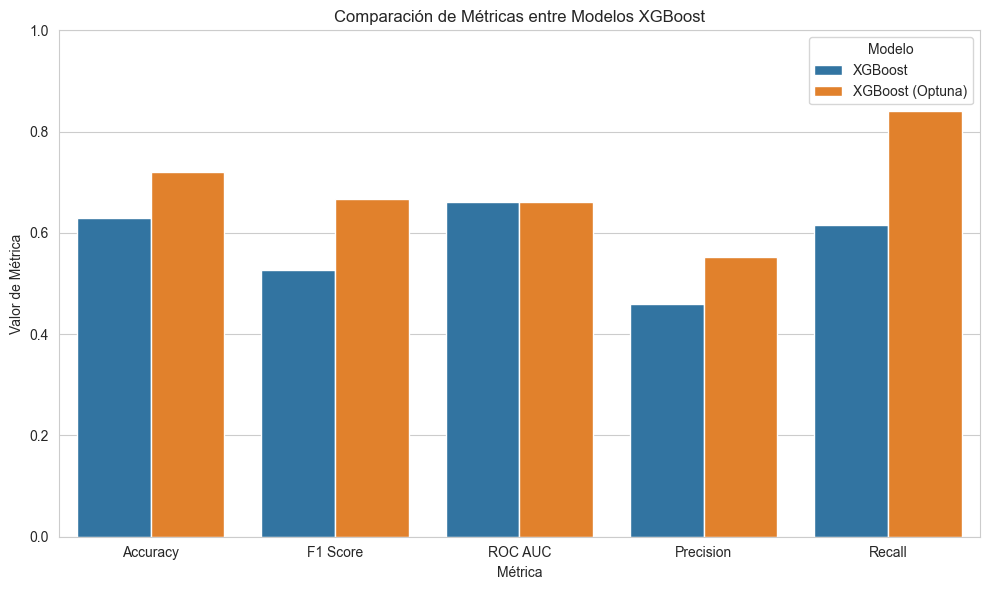

In [26]:
# Transformar datos para seaborn
df_melt = metrics_df_XGBoost.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

# Configuración gráfica
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt, x='Métrica', y='Valor', hue='Modelo')

# Mejoras visuales
plt.title('Comparación de Métricas entre Modelos XGBoost')
plt.ylim(0, 1)  # Las métricas están entre 0 y 1
plt.legend(title='Modelo')
plt.ylabel('Valor de Métrica')
plt.xlabel('Métrica')
plt.tight_layout()

# Mostrar
plt.show()